In [1]:
import json
import joblib
import pickle
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score
import matplotlib.pyplot as plt
from uuid import uuid4
from flask import Flask, jsonify, request
import requests

In [2]:
df = pd.read_csv("train.csv")
df.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01T00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01T00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01T00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01T00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01T00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall


# Information about dataframe

In [3]:
df.shape

(660611, 16)

In [4]:
df.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660611 entries, 0 to 660610
Data columns (total 16 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   observation_id                            660611 non-null  object 
 1   Type                                      660611 non-null  object 
 2   Date                                      660611 non-null  object 
 3   Part of a policing operation              507047 non-null  object 
 4   Latitude                                  548295 non-null  float64
 5   Longitude                                 548295 non-null  float64
 6   Gender                                    660611 non-null  object 
 7   Age range                                 660611 non-null  object 
 8   Self-defined ethnicity                    655037 non-null  object 
 9   Officer-defined ethnicity                 660611 non-null  object 
 10  Legislation         

In [6]:
660611-234062

426549

In [7]:
#Results: 

# Information about columns

Observation_id

In [8]:
df['observation_id'].value_counts()

522cf527-453f-4fa8-adc7-47de4a2911e5    1
dadd0830-8413-4807-b086-9316604cb83a    1
11aaa251-9cba-4ae4-b927-fd4a7fc625fe    1
4015be40-f8a9-4258-82ba-ada0c3148187    1
bd7564e3-50c6-4d00-acc1-2e5a0587d8aa    1
                                       ..
54d7d4bc-caf4-45fd-9a36-8424093050b2    1
3955c51a-6dde-4673-8b32-431498b0c545    1
d3c0080f-f86c-402a-8491-5970cbccdb6f    1
104d1bf2-a208-4f2a-a554-576e357ceef8    1
786df035-7ede-4e57-9562-31833915b25b    1
Name: observation_id, Length: 660611, dtype: int64

In [9]:
#Decision : remove observation_id because it is unique(len of series is equal to the number of rows of df) and do not add anything to our model

Type

In [10]:
df.Type.unique()

array(['Person search', 'Person and Vehicle search', 'Vehicle search'],
      dtype=object)

In [11]:
df.Type.value_counts()

Person search                503503
Person and Vehicle search    156156
Vehicle search                  952
Name: Type, dtype: int64

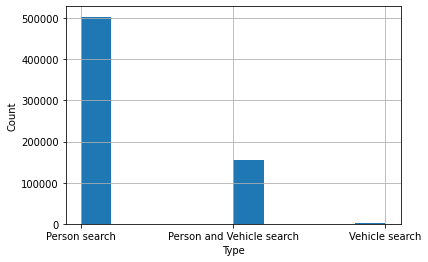

In [12]:
df.Type.hist()
plt.xlabel('Type');
plt.ylabel('Count');

Part of a policing operation

In [13]:
df['Part of a policing operation'].unique()

array([True, False, nan], dtype=object)

In [14]:
df['Part of a policing operation'].value_counts()

False    490773
True      16274
Name: Part of a policing operation, dtype: int64

In [15]:
df['Part of a policing operation'].isnull().sum()

153564

Text(0, 0.5, 'Count')

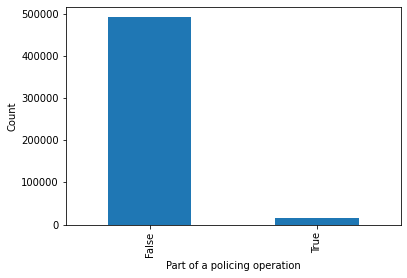

In [16]:
df['Part of a policing operation'].value_counts().plot.bar()
plt.xlabel('Part of a policing operation')
plt.ylabel('Count')

In [17]:
#Decision : I need more information about this column

Latitude, Langitude, station

In [18]:
df.loc[:,['Latitude','Longitude','station']].isnull().sum()

Latitude     112316
Longitude    112316
station           0
dtype: int64

In [19]:
df.Latitude.value_counts()

51.378427    1286
51.402747    1243
51.539189    1104
51.522956     830
51.516120     827
             ... 
50.819422       1
52.016083       1
52.266771       1
53.232820       1
51.517360       1
Name: Latitude, Length: 103638, dtype: int64

In [20]:
df.loc[:,['Latitude','Longitude','station']].tail(n=40)

,Latitude,Longitude,station
660571,51.372929,-2.125311,wiltshire
660572,51.254789,-2.195532,wiltshire
660573,51.303239,-2.228645,wiltshire
660574,51.303239,-2.228645,wiltshire
660575,51.068597,-1.796761,wiltshire
660576,51.458875,-2.121041,wiltshire
660577,51.458875,-2.121041,wiltshire
660578,51.458875,-2.121041,wiltshire
660579,51.458875,-2.121041,wiltshire
660580,NaN,NaN,wiltshire


In [21]:
df.Latitude.min()

49.892149

In [22]:
df.Latitude.max()

57.14385600000001

In [23]:
df.Longitude.min()

-8.053397

In [24]:
df.Longitude.max()

1.7564799999999998

In [25]:
df.station.value_counts()

metropolitan          351294
merseyside             41597
essex                  19039
thames-valley          17898
west-yorkshire         17144
hampshire              13963
hertfordshire          13328
kent                   13309
south-yorkshire        13165
surrey                 10972
avon-and-somerset      10015
btp                     9555
lancashire              9154
west-mercia             7904
devon-and-cornwall      7569
staffordshire           7318
nottinghamshire         7103
northumbria             7049
sussex                  6941
north-wales             5215
lincolnshire            5047
leicestershire          4980
greater-manchester      4851
cheshire                4845
norfolk                 4779
dyfed-powys             4315
bedfordshire            4209
humberside              3783
city-of-london          3575
northamptonshire        3526
suffolk                 3355
warwickshire            3249
gloucestershire         2871
derbyshire              2852
dorset        

In [26]:
##I keep all 3 features and fill nans with strategy mean() for latitude and Langitude

Gender

In [27]:
df.Gender.value_counts()

Male      605422
Female     54812
Other        377
Name: Gender, dtype: int64

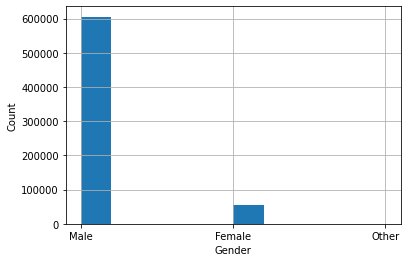

In [28]:
df.Gender.hist()
plt.xlabel('Gender');
plt.ylabel('Count');

In [29]:
df[df.Gender=='Other'].Outcome.value_counts()

A no further action disposal               267
Arrest                                      39
Community resolution                        23
Nothing found - no further action           14
Khat or Cannabis warning                     9
Summons / charged by post                    7
Caution (simple or conditional)              5
Offender given drugs possession warning      4
Suspect arrested                             4
Penalty Notice for Disorder                  4
Suspect summonsed to court                   1
Name: Outcome, dtype: int64

In [30]:
df[df.Gender=='Other']['Age range'].value_counts()

18-24       126
10-17        85
25-34        83
over 34      80
under 10      3
Name: Age range, dtype: int64

In [31]:
#Result
#There's a clear disparity between samples for each gender,
#this might be a problem not only to train the model but to efficiently analyze its biases.
# there is also other group wich can be removed from our analysis or can be go to the F group
#Remove Other from analysis

In [32]:
df.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station'],
      dtype='object')

Age range

In [33]:
df['Age range'].value_counts()

18-24       241905
25-34       158181
10-17       131763
over 34     128378
under 10       384
Name: Age range, dtype: int64

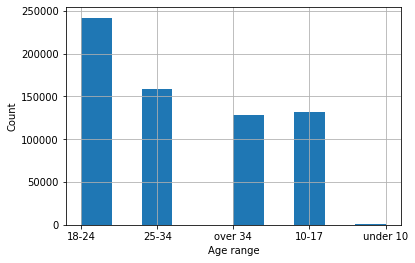

In [34]:
#remove under 10 age
df['Age range'].hist()
plt.xlabel('Age range');
plt.ylabel('Count');

In [35]:
df.loc[df['Age range']=='under 10',:]

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
429,ea483461-7a08-4e70-aa6a-4a25e61ddef1,Person search,2019-12-11T00:00:00+00:00,NaN,NaN,NaN,Male,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,dyfed-powys
779,cfc269b8-e34d-4239-a4dc-f052b56a8022,Person search,2019-12-04T17:30:00+00:00,False,NaN,NaN,Female,under 10,White - Any other White background,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,NaN,False,bedfordshire
791,0f8419da-0c79-4140-9834-cf930682be2a,Person search,2019-12-06T12:30:00+00:00,True,51.916449,-0.662798,Male,under 10,White - Irish,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,True,False,bedfordshire
5119,82bacd9c-c038-431d-a865-a0285efa3635,Person search,2019-12-24T19:33:00+00:00,False,52.603583,0.361754,Male,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,A no further action disposal,False,False,norfolk
5566,2dac968f-0102-4943-bba4-a3375f876c2d,Person and Vehicle search,2019-12-05T21:20:00+00:00,False,NaN,NaN,Male,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,NaN,Article for use in theft,A no further action disposal,NaN,NaN,thames-valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658660,d6afe90a-dedf-4732-b3ac-a910cc11f895,Person search,2018-08-09T20:11:00+00:00,False,53.579219,-2.462290,Female,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,greater-manchester
658733,a0c06e71-86a4-4870-9581-712a3e0f4102,Person and Vehicle search,2018-08-18T21:01:00+00:00,False,53.581433,-2.402079,Male,under 10,Asian/Asian British - Indian,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,greater-manchester
658741,b67a2798-6e83-4bb4-8506-ed63dfd5aae8,Person search,2018-08-20T01:40:00+00:00,False,53.557421,-2.136697,Male,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,A no further action disposal,NaN,False,greater-manchester
659332,7f084687-3720-4899-9659-c254187d39dc,Person search,2018-08-27T10:15:00+00:00,NaN,51.541790,-0.002183,Male,under 10,Black/African/Caribbean/Black British - Any ot...,Black,Criminal Justice and Public Order Act 1994 (se...,Offensive weapons,A no further action disposal,True,False,btp


In [36]:
df.loc[df['Age range']=='under 10',:].Outcome.value_counts()

A no further action disposal                    284
Arrest                                           31
Community resolution                             21
Nothing found - no further action                15
Khat or Cannabis warning                         14
Summons / charged by post                         5
Penalty Notice for Disorder                       4
Local resolution                                  3
Caution (simple or conditional)                   3
Suspect arrested                                  2
Article found - Detailed outcome unavailable      1
Offender given drugs possession warning           1
Name: Outcome, dtype: int64

In [37]:
#Comment: The number of under 10 is very low(384) and among them 284 person are inocent. 
#It will effect on the analysis later on. There is bias in the date 

Self-defined ethnicity

In [38]:
df['Self-defined ethnicity'].value_counts()

White - English/Welsh/Scottish/Northern Irish/British                                   272053
Other ethnic group - Not stated                                                          86421
White - Any other White background                                                       57875
Black/African/Caribbean/Black British - Any other Black/African/Caribbean background     54036
Black/African/Caribbean/Black British - African                                          43297
Black/African/Caribbean/Black British - Caribbean                                        31315
Asian/Asian British - Any other Asian background                                         29169
Asian/Asian British - Bangladeshi                                                        17083
Asian/Asian British - Pakistani                                                          15720
Other ethnic group - Any other ethnic group                                              11276
Mixed/Multiple ethnic groups - Any other Mixed/Mul

In [39]:
df['Self-defined ethnicity'].isnull().sum()

5574

<AxesSubplot:>

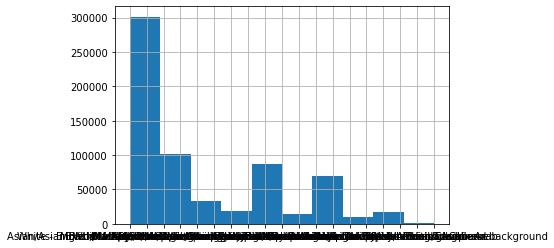

In [40]:
df['Self-defined ethnicity'].hist()

In [41]:
B = df['Self-defined ethnicity'].value_counts().values[3]+df['Self-defined ethnicity'].value_counts().values[4]+df['Self-defined ethnicity'].value_counts().values[5]
print("the number of blacks in Self-defined ethnicity is :{}".format(B))

the number of blacks in Self-defined ethnicity is :128648


In [42]:
W = df['Self-defined ethnicity'].value_counts().values[0]+df['Self-defined ethnicity'].value_counts().values[2]+df['Self-defined ethnicity'].value_counts().values[13]+df['Self-defined ethnicity'].value_counts().values[17]
print("the number of whites in Self-defined ethnicity is :{}".format(W))

the number of whites in Self-defined ethnicity is :335742


In [43]:
A = df['Self-defined ethnicity'].value_counts().values[6]+df['Self-defined ethnicity'].value_counts().values[7]+df['Self-defined ethnicity'].value_counts().values[8]+df['Self-defined ethnicity'].value_counts().values[11]+df['Self-defined ethnicity'].value_counts().values[16]
print("the number of asians in Self-defined ethnicity is :{}".format(A))

the number of asians in Self-defined ethnicity is :71092


In [44]:
#It has 5574 null and presenting this column will not effect on the analysis we just use officer defined etnicity
#Decision: remove self defined ethnicity

Officer-defined ethnicity

In [45]:
df['Officer-defined ethnicity'].value_counts()

White    378311
Black    174593
Asian     86035
Other     19842
Mixed      1830
Name: Officer-defined ethnicity, dtype: int64

Text(0, 0.5, 'Count')

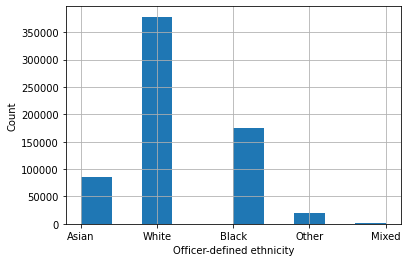

In [46]:
df['Officer-defined ethnicity'].hist()
plt.xlabel('Officer-defined ethnicity')
plt.ylabel('Count')

In [47]:
#Comment:Mixed is bias I need to do something for that. Other also is bias.

Legislation

In [48]:
df['Legislation'].value_counts()

Misuse of Drugs Act 1971 (section 23)                      385307
Police and Criminal Evidence Act 1984 (section 1)          224682
Criminal Justice and Public Order Act 1994 (section 60)     17259
Firearms Act 1968 (section 47)                               4352
Criminal Justice Act 1988 (section 139B)                      746
Poaching Prevention Act 1862 (section 2)                      152
Psychoactive Substances Act 2016 (s36(2))                      90
Wildlife and Countryside Act 1981 (section 19)                 31
Police and Criminal Evidence Act 1984 (section 6)              15
Aviation Security Act 1982 (section 27(1))                     11
Customs and Excise Management Act 1979 (section 163)           10
Crossbows Act 1987 (section 4)                                  5
Protection of Badgers Act 1992 (section 11)                     4
Psychoactive Substances Act 2016 (s37(2))                       4
Public Stores Act 1875 (section 6)                              1
Deer Act 1

In [49]:
#One hot encoder
# remove under 10 values

Object of search

In [50]:
df['Object of search'].value_counts()

Controlled drugs                              398873
Offensive weapons                             102107
Stolen goods                                   67636
Article for use in theft                       30836
Evidence of offences under the Act             19911
Anything to threaten or harm anyone            19762
Articles for use in criminal damage            11060
Firearms                                        5479
Fireworks                                       2948
Psychoactive substances                         1701
Detailed object of search unavailable            129
Game or poaching equipment                       102
Evidence of wildlife offences                     25
Goods on which duty has not been paid etc.        23
Crossbows                                         17
Seals or hunting equipment                         2
Name: Object of search, dtype: int64

In [51]:
#one hot encoder we will use

Outcome

In [52]:
df['Outcome'].value_counts()

A no further action disposal                                    455342
Arrest                                                           94118
Community resolution                                             41311
Khat or Cannabis warning                                         17173
Nothing found - no further action                                16188
Summons / charged by post                                        12232
Penalty Notice for Disorder                                      11214
Suspect arrested                                                  4649
Caution (simple or conditional)                                   3179
Offender given drugs possession warning                           2102
Local resolution                                                  1333
Suspect summonsed to court                                         636
Article found - Detailed outcome unavailable                       524
Offender given penalty notice                                      414
Offend

In [53]:
 print("The totall number of no action after searching is:{}".format(df['Outcome'].value_counts()[0]+df['Outcome'].value_counts()[4]))

The totall number of no action after searching is:471530


In [54]:
#We built our target according to this so it will be removed form analysis

Outcome linked to object of search


In [55]:
df['Outcome linked to object of search'].value_counts()

True     100273
False     87238
Name: Outcome linked to object of search, dtype: int64

In [56]:
df['Outcome linked to object of search'].isnull().sum()

473100

In [57]:
df['Outcome linked to object of search'].unique()

array([nan, True, False], dtype=object)

Text(0, 0.5, 'Count')

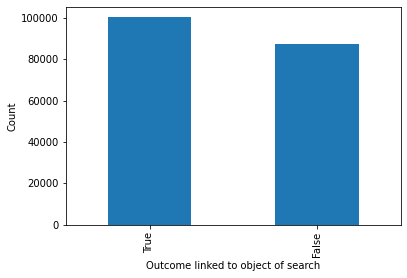

In [58]:
df['Outcome linked to object of search'].value_counts().plot.bar()
plt.xlabel('Outcome linked to object of search')
plt.ylabel('Count')

Removal of more than just outer clothing

In [59]:
print("The number of nan vaues in the 'Outcome linked to object of search' column is :{}".format(df['Outcome linked to object of search'].isnull().sum()))

The number of nan vaues in the 'Outcome linked to object of search' column is :473100


In [60]:
#Decision: This column will be considered by target the target is true if this column related to search object is true and 
#outcome be  Local resolution
#Community resolution
#Offender given drugs possession warning
#Khat or Cannabis warning
#Caution (simple or conditional)
#Offender given penalty notice
#Arrest
#Penalty Notice for Disorder
#Suspected psychoactive substances seized - No further action
#Summons / charged by post
#Article found - Detailed outcome unavailable
#Offender cautioned
#Suspect arrested
#Suspect summonsed to court


Removal of more than just outer clothing

In [61]:
df['Removal of more than just outer clothing'].isnull().sum()

426549

In [62]:
df['Removal of more than just outer clothing'].unique()

array([False, True, nan], dtype=object)

In [63]:
df['Removal of more than just outer clothing'].value_counts()

False    223397
True      10665
Name: Removal of more than just outer clothing, dtype: int64

Text(0, 0.5, 'Count')

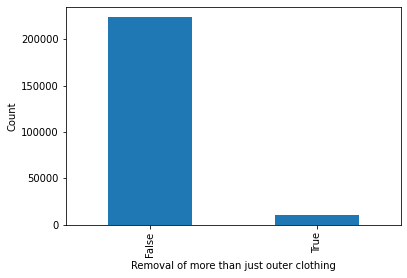

In [64]:
#information of this column is  baias
df['Removal of more than just outer clothing'].value_counts().plot.bar()
plt.xlabel('Removal of more than just outer clothing')
plt.ylabel('Count')

In [65]:
#Bias how we could decide according to this value will be difficult.

Station

In [66]:
df['station'].value_counts()

metropolitan          351294
merseyside             41597
essex                  19039
thames-valley          17898
west-yorkshire         17144
hampshire              13963
hertfordshire          13328
kent                   13309
south-yorkshire        13165
surrey                 10972
avon-and-somerset      10015
btp                     9555
lancashire              9154
west-mercia             7904
devon-and-cornwall      7569
staffordshire           7318
nottinghamshire         7103
northumbria             7049
sussex                  6941
north-wales             5215
lincolnshire            5047
leicestershire          4980
greater-manchester      4851
cheshire                4845
norfolk                 4779
dyfed-powys             4315
bedfordshire            4209
humberside              3783
city-of-london          3575
northamptonshire        3526
suffolk                 3355
warwickshire            3249
gloucestershire         2871
derbyshire              2852
dorset        

In [67]:
len(df['station'].unique())

42

In [68]:
#Keep the station

# Target Built(From Outcome)

In [69]:
df['Outcome'].unique()

array(['A no further action disposal', 'Arrest', 'Community resolution',
       'Summons / charged by post', 'Khat or Cannabis warning',
       'Caution (simple or conditional)', 'Penalty Notice for Disorder',
       'Nothing found - no further action',
       'Offender given drugs possession warning', 'Local resolution',
       'Suspect arrested', 'Article found - Detailed outcome unavailable',
       'Offender cautioned', 'Suspect summonsed to court',
       'Offender given penalty notice',
       'Suspected psychoactive substances seized - No further action'],
      dtype=object)

In [70]:
#build target from outcome column true means the search was succesfull and police find something False means the polica did search but could not find anythong.
df['target'] =True
df.loc[df['Outcome']=='A no further action disposal','target'] =False
df.loc[df['Outcome']== 'Nothing found - no further action','target']=False
df

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01T00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01T00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01T00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01T00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01T00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660606,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29T02:45:00+00:00,NaN,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN,wiltshire,False
660607,425fde18-f7d5-4ebe-baf4-714cadd5a445,Person and Vehicle search,2018-08-29T21:00:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Penalty Notice for Disorder,True,False,wiltshire,True
660608,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29T21:10:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,wiltshire,False
660609,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29T21:15:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,wiltshire,False


Target chack values

In [71]:
#count the values
df['target'].value_counts()

False    471530
True     189081
Name: target, dtype: int64

Text(0, 0.5, 'Count')

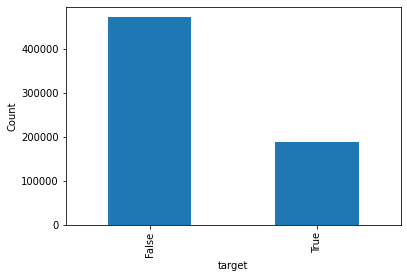

In [72]:
#plot
df['target'].value_counts().plot.bar()
plt.xlabel('target')
plt.ylabel('Count')

# Comparing columns with eachother

In [73]:
df.groupby(['Outcome', 
            'Outcome linked to object of search'])['Legislation'].count().unstack()

Outcome linked to object of search,False,True
Outcome,,
A no further action disposal,53206,35627
Arrest,11299,25800
Article found - Detailed outcome unavailable,158,243
Caution (simple or conditional),350,2231
Community resolution,3398,7192
Khat or Cannabis warning,1482,11561
Local resolution,649,434
Nothing found - no further action,3271,1445
Offender cautioned,25,136


In [74]:
df.groupby(['Object of search', 
            'Outcome linked to object of search'])['Legislation'].count().unstack()

Outcome linked to object of search,False,True
Object of search,,
Anything to threaten or harm anyone,1470.0,1134.0
Article for use in theft,9190.0,7319.0
Articles for use in criminal damage,1011.0,723.0
Controlled drugs,43546.0,65775.0
Crossbows,6.0,5.0
Detailed object of search unavailable,14.0,76.0
Evidence of offences under the Act,901.0,407.0
Evidence of wildlife offences,6.0,11.0
Firearms,831.0,761.0


In [75]:
df.groupby(['Officer-defined ethnicity', 
            'Self-defined ethnicity'])['Longitude'].count().unstack()


Self-defined ethnicity,Asian/Asian British - Any other Asian background,Asian/Asian British - Bangladeshi,Asian/Asian British - Chinese,Asian/Asian British - Indian,Asian/Asian British - Pakistani,Black/African/Caribbean/Black British - African,Black/African/Caribbean/Black British - Any other Black/African/Caribbean background,Black/African/Caribbean/Black British - Caribbean,Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background,Mixed/Multiple ethnic groups - White and Asian,Mixed/Multiple ethnic groups - White and Black African,Mixed/Multiple ethnic groups - White and Black Caribbean,Other ethnic group - Any other ethnic group,Other ethnic group - Arab,Other ethnic group - Not stated,White - Any other White background,White - English/Welsh/Scottish/Northern Irish/British,White - Gypsy or Irish Traveller,White - Irish
Officer-defined ethnicity,,,,,,,,,,,,,,,,,,,
Asian,21617,15183,518,6674,11477,371,343,114,956,845,60,59,1462,12,11085,421,637,9,11
Black,586,133,94,124,91,36992,47076,26884,2955,71,1520,5081,1096,5,28072,304,1087,7,38
Mixed,14,2,1,3,8,18,76,44,302,56,93,236,22,2,483,71,63,1,0
Other,2691,71,137,72,172,452,369,44,1500,188,173,313,3693,63,5458,1372,639,3,17
White,534,59,60,114,122,295,419,207,2603,441,175,581,3609,3,27256,48295,213687,592,4167


In [76]:
df.groupby(['Gender', 
            'target'])['Longitude'].count().unstack()

target,False,True
Gender,,
Female,31997,12014
Male,357993,145963
Other,239,89


In [77]:
df.groupby(['Officer-defined ethnicity', 
            'target'])['Longitude'].count().unstack()


target,False,True
Officer-defined ethnicity,,
Asian,51587,20492
Black,109889,42690
Mixed,1073,484
Other,12534,4963
White,215146,89437


In [78]:
df.groupby(['Officer-defined ethnicity', 
            'Removal of more than just outer clothing'])['Longitude'].count().unstack()

Removal of more than just outer clothing,False,True
Officer-defined ethnicity,,
Asian,12304,775
Black,17362,1957
Mixed,1157,93
Other,3496,173
White,145650,5698


In [79]:
df.groupby(['Gender', 
            'Removal of more than just outer clothing'])['Longitude'].count().unstack()

Removal of more than just outer clothing,False,True
Gender,,
Female,17463,1039
Male,162328,7646
Other,178,11


In [80]:
df[df.Gender=='Other'].target.value_counts()

False    281
True      96
Name: target, dtype: int64

In [81]:
df.loc[df[df.station=='metropolitan'].index,['Outcome linked to object of search','Removal of more than just outer clothing']]

,Outcome linked to object of search,Removal of more than just outer clothing
7304,NaN,NaN
7305,NaN,NaN
7306,NaN,NaN
7307,NaN,NaN
7308,NaN,NaN
...,...,...
650365,NaN,NaN
650366,NaN,NaN
650367,NaN,NaN
650368,NaN,NaN


In [82]:
df.loc[df.station=='metropolitan',['Outcome linked to object of search','Removal of more than just outer clothing']]

,Outcome linked to object of search,Removal of more than just outer clothing
7304,NaN,NaN
7305,NaN,NaN
7306,NaN,NaN
7307,NaN,NaN
7308,NaN,NaN
...,...,...
650365,NaN,NaN
650366,NaN,NaN
650367,NaN,NaN
650368,NaN,NaN


# Dealing with datetime features

In [83]:

df['Date'] = pd.to_datetime(df['Date'])

# get the hour and day of the week, maybe they will be useful 
df['hour'] = df['Date'].dt.hour
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.day_name()
df

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day_of_week
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01 00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,0,12,Sunday
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01 00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,0,12,Sunday
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01 00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,0,12,Sunday
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01 00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,0,12,Sunday
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01 00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,0,12,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660606,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29 02:45:00+00:00,NaN,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN,wiltshire,False,2,8,Wednesday
660607,425fde18-f7d5-4ebe-baf4-714cadd5a445,Person and Vehicle search,2018-08-29 21:00:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Penalty Notice for Disorder,True,False,wiltshire,True,21,8,Wednesday
660608,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29 21:10:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,wiltshire,False,21,8,Wednesday
660609,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29 21:15:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,wiltshire,False,21,8,Wednesday


In [84]:
#decision: ignoring the time and adding hour month and day_of_week columns from original Date column

# Cleaning the data frame

In [85]:
#remove some rows like other in grnder and metropolitan in station(Later I will write a function for that)

In [86]:
#remove metropolitan station from our analysis
df = df.copy()
mask = df['station']=='metropolitan'
metro_station_index = df[mask].index
df = df.drop(metro_station_index)
df.shape
#remove other from gender from our analysis
mask = df['Gender']=='Other'
Other_Gender_index = df[mask].index
df = df.drop(Other_Gender_index)
df.shape

(309045, 20)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309045 entries, 0 to 660610
Data columns (total 20 columns):
 #   Column                                    Non-Null Count   Dtype              
---  ------                                    --------------   -----              
 0   observation_id                            309045 non-null  object             
 1   Type                                      309045 non-null  object             
 2   Date                                      309045 non-null  datetime64[ns, UTC]
 3   Part of a policing operation              155607 non-null  object             
 4   Latitude                                  230021 non-null  float64            
 5   Longitude                                 230021 non-null  float64            
 6   Gender                                    309045 non-null  object             
 7   Age range                                 309045 non-null  object             
 8   Self-defined ethnicity                    30

# build new target according to outcome lined to object of search(This is true target for training)

In [90]:
# build new dataframe for training

df_search = df[(df['Outcome linked to object of search'] == True) | (df['target'] == True) ]
df_search.info()
df_search['Outcome linked to object of search'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130732 entries, 16 to 660610
Data columns (total 20 columns):
 #   Column                                    Non-Null Count   Dtype              
---  ------                                    --------------   -----              
 0   observation_id                            130732 non-null  object             
 1   Type                                      130732 non-null  object             
 2   Date                                      130732 non-null  datetime64[ns, UTC]
 3   Part of a policing operation              73170 non-null   object             
 4   Latitude                                  102278 non-null  float64            
 5   Longitude                                 102278 non-null  float64            
 6   Gender                                    130732 non-null  object             
 7   Age range                                 130732 non-null  object             
 8   Self-defined ethnicity                    1

True     100210
False     23188
Name: Outcome linked to object of search, dtype: int64

# Check if after cleaning the outcome ot target is bias

In [91]:
df.target.value_counts()

False    216285
True      92760
Name: target, dtype: int64

<AxesSubplot:>

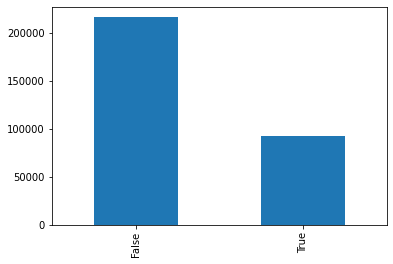

In [92]:
df.target.value_counts().plot.bar()

In [93]:
# check for df_search
df_search['target'].value_counts()

True     92760
False    37972
Name: target, dtype: int64

<AxesSubplot:>

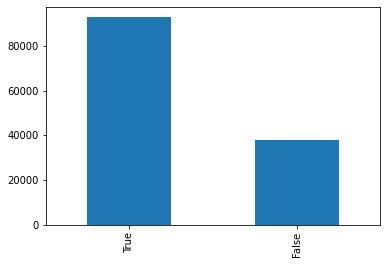

In [94]:
df_search.target.value_counts().plot.bar()

# Percentage of true and false in target for df

In [95]:
len_target = df.shape[0]
target_false_percentage = df.target.value_counts()[0]*100/len_target
target_true_percentage = df.target.value_counts()[1]*100/len_target
print("target_false_percentage:{},target_true_percentage:{}".format(target_false_percentage,target_true_percentage))

target_false_percentage:69.98495364752706,target_true_percentage:30.01504635247294


# Percentage of true and false in target for df_search

In [96]:
len_target = df_search.shape[0]
target_false_percentage = df_search.target.value_counts()[0]*100/len_target
target_true_percentage = df_search.target.value_counts()[1]*100/len_target
print("target_false_percentage:{},target_true_percentage:{}".format(target_false_percentage,target_true_percentage))

target_false_percentage:29.045681241012147,target_true_percentage:70.95431875898785


In [ ]:
df_search.groupby(['Object', 
            'Removal of more than just outer clothing'])['Longitude'].count().unstack()

# Training the model

In [97]:
df_train,df_test = train_test_split(df_search, test_size=0.25, random_state=42)

In [98]:
df_train.shape

(98049, 20)

In [99]:
df_test.shape

(32683, 20)

In [100]:
# lowercaes departments and location names
#df['Type'] = df['Type'].apply(lambda x: str(x).lower())
#df['station'] = df['station'].apply(lambda x: str(x).lower())
#df['Officer-defined ethnicity'] = df['Officer-defined ethnicity'].apply(lambda x: str(x).lower())

In [101]:
target = 'target'


all_features = [
  'Type', 'Part of a policing operation','Latitude', 'Longitude',
       'Gender', 'Legislation','Object of search', 'Age range',
       'Officer-defined ethnicity',
       'Removal of more than just outer clothing', 'station','hour', 'month', 'day_of_week'
]

numerical_features = ['Latitude', 'Longitude','hour','month']
categorical_features_obj = [
   'Type',
       'Gender','Legislation','Object of search', 'Age range',
       'Officer-defined ethnicity',
        'station', 'day_of_week'
]
categorical_features_bool = ['Part of a policing operation','Removal of more than just outer clothing']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer_obj = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer_bool = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat_obj', categorical_transformer_obj, categorical_features_obj),
        ('cat_bool',categorical_transformer_bool, categorical_features_bool)])

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1),
)


X_train = df_train[all_features]
y_train = df_train[target]

pipeline.fit(X_train, y_train)

X_test = df_test[all_features]
y_test = df_test[target]

y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# To use on other cells
X_train_baseline = X_train.copy()
X_test_baseline = X_test.copy()
y_train_baseline = y_train.copy()
y_test_baseline = y_test.copy()
y_pred_baseline = y_pred.copy()
pipeline_baseline = pipeline

print('roc_auc_score: ', roc_auc_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))
#accuracy is wrong metric for imbalance data
print('acuracy_score: ', accuracy_score(y_test, y_pred))


roc_auc_score:  0.712435597872491
f1_score:  0.7953302048758156
acuracy_score:  0.7264327020163388


In [102]:
y_pred_proba = pipeline.predict_proba(X_test)
y_pred_proba[:,1]

array([0.56631853, 0.48840687, 0.59235635, ..., 0.56196861, 0.66995206,
       0.43924285])

In [103]:
y_pred

array([ True, False,  True, ...,  True,  True, False])

In [104]:
with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)
    

joblib.dump(pipeline, 'pipeline.pickle') 

with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)

In [105]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.1):
    """
    Verifies the success rate on a test set is above a provided minimum
    
    
    """
    
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    
    return is_satisfied, precision


In [106]:
verify_success_rate_above(y_test, y_pred, min_success_rate=0.1)

(True, 0.8526134969325153)

In [107]:
def verify_amount_found(y_true, y_pred):
    """
    Verifies the amout ofpositive search in the test dataset - a.k.a the recall in our test set
    """
    
    recall = recall_score(y_true, y_pred)    
    return recall


In [108]:
verify_amount_found(y_test, y_pred)

0.7452595452595453

In [109]:
df.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station', 'target', 'hour',
       'month', 'day_of_week'],
      dtype='object')

In [110]:
station_names = df.station.unique()
station_names

array(['devon-and-cornwall', 'dyfed-powys', 'derbyshire', 'bedfordshire',
       'avon-and-somerset', 'cheshire', 'sussex', 'north-yorkshire',
       'cleveland', 'merseyside', 'north-wales', 'wiltshire', 'norfolk',
       'suffolk', 'thames-valley', 'durham', 'warwickshire',
       'leicestershire', 'hertfordshire', 'cumbria', 'essex',
       'south-yorkshire', 'surrey', 'staffordshire', 'northamptonshire',
       'northumbria', 'city-of-london', 'nottinghamshire',
       'gloucestershire', 'cambridgeshire', 'lincolnshire', 'btp',
       'west-yorkshire', 'dorset', 'west-mercia', 'kent', 'hampshire',
       'humberside', 'lancashire', 'greater-manchester', 'gwent'],
      dtype=object)

def verify_no_discrimination(X_test, y_test, y_pred, sensitive_column='Removal of more than just outer clothing', max_diff=0.05):
    """
    Verifies that no station has discrimination in between protected races
    
    
    """
    
    stations = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_stations = []
    good_stations = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['Department Name'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_deparments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_deparments

# Check server locally

In [111]:
# use command "python app.py" in ubontu in the directory of the capston 6

In [116]:
observation = {
  "observation_id": "fake-observation-{}".format(uuid4()),
  "observation":{
      "Type":"Person search",
        "Part of a policing operation":True,
        "Latitude":53.5,
        "Longitude":1.,
        "Gender":"Female",
        "Legislation":'Misuse of Drugs Act 1971 (section 23)',
        "Object of search":"Controlled drugs",
        "Age range":"over 34",
        "Officer-defined ethnicity":"White",
        "Removal of more than just outer clothing":False,
        "station":"wiltshire",
        "hour":10,
        "month":2,
        "day_of_week":"Thursday",
  }}

In [117]:
print(json.dumps(observation))

{"observation_id": "fake-observation-1ac20d19-f55c-4630-880f-9cdb1a449104", "observation": {"Type": "Person search", "Part of a policing operation": true, "Latitude": 53.5, "Longitude": 1.0, "Gender": "Female", "Legislation": "Misuse of Drugs Act 1971 (section 23)", "Object of search": "Controlled drugs", "Age range": "over 34", "Officer-defined ethnicity": "White", "Removal of more than just outer clothing": false, "station": "wiltshire", "hour": 10, "month": 2, "day_of_week": "Thursday"}}


In [118]:
url="http://127.0.0.1:5000/predict"
headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(observation), headers=headers)

print(r.status_code)
print(r.text)

200
{"observation_id":"fake-observation-1ac20d19-f55c-4630-880f-9cdb1a449104","prediction":true,"proba":0.5393660456278457}



In [115]:
#pip install requests